In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

## Download Stock Data

In [2]:
tickers = 'MSFT CS'
stock_count = len(tickers.split(' '))
sd = '2018-01-01'
ed = '2022-12-31'

In [3]:
df = yf.download(tickers, start=sd, end=ed)

[*********************100%%**********************]  2 of 2 completed


1 Failed download:
['CS']: Exception('%ticker%: No timezone found, symbol may be delisted')


In [4]:
adj_close = df.loc[:,  df.columns.get_level_values(0) == 'Adj Close']
adj_close.columns = adj_close.columns.droplevel(0)

## Helper Functions
One to calc returns, another for central moments. Used in questions 3 and 4.

In [5]:
def calc_returns(prices, return_type, dropna=True):
    assert return_type in ['arithmetic', 'logarithmic']
    if return_type == 'arithmetic':
        rts = (prices / prices.shift(1) - 1)
    else:
        rts = (np.log(prices / prices.shift(1)))
    if dropna:
        rts = rts.dropna(axis=0)
    return rts
    
def calc_central_moments(rts, return_type=None):
    """
    Helper function to calc central moments.
    NOTE: the return_type input doesn't actually change the calc, it's strictly for formatting.
    """
    
    n = rts.shape[0]
    if isinstance(rts, pd.Series):
        rts = rts.to_frame()
    stats = pd.DataFrame(columns=rts.columns)
    mean = (1/n * (rts)).sum(axis=0)
    var = (1/n * ((rts - mean)**2)).sum(axis=0)
    std = var**(1/2)
    stats.loc['mean', :] = mean
    stats.loc['variance', :] = var
    stats.loc['skewness', :] = (1/(n*(std**3))) * ((rts - mean)**3).sum(axis=0)
    stats.loc['kurtosis', :] = (1/(n*(std**4))) * ((rts - mean)**4).sum(axis=0)
    if return_type:
        stats.index = pd.MultiIndex.from_product([[return_type], stats.index])
    return stats

## Question 3

#### (a) Calculate daily arithmetic and logarithmic returns

In [6]:
# arithmetic returns = P1/P0-1
rts_a = calc_returns(adj_close, return_type='arithmetic')
# log returns = ln(P1/P0)
rts_l = calc_returns(adj_close, return_type='logarithmic')

#### (b) Calculate mean, variance, skewness, kurtosis of arithmetic and log returns

In [7]:
stats_a = calc_central_moments(rts_a, 'arithmetic')
stats_l = calc_central_moments(rts_l, 'logarithmic')
pd.concat([stats_a, stats_l])

AAPL      EBAY      GOOG       INTC       MSFT  \
arithmetic  mean      0.001141  0.000334  0.000601  -0.000057   0.001055   
            variance  0.000445  0.000437   0.00039   0.000571   0.000382   
            skewness -0.026081 -0.105765  -0.03245  -0.210541  -0.018479   
            kurtosis  7.466777    7.4702  6.805975  13.443167   9.713268   
logarithmic mean      0.000918  0.000115  0.000406  -0.000345   0.000863   
            variance  0.000445  0.000439   0.00039   0.000578   0.000382   
            skewness -0.232019 -0.307219 -0.204622  -0.661023  -0.278449   
            kurtosis  7.613514  7.496776  6.866321  14.123155  10.102705   

                           ORCL  
arithmetic  mean       0.000687  
            variance   0.000355  
            skewness   1.192488  
            kurtosis  21.945432  
logarithmic mean       0.000512  
            variance   0.000349  
            skewness    0.68757  
            kurtosis  18.572872

#### (c) Create equally weighted portfolio, calculate value each day. From value calculate arithmetic and log returns. Then compute the central moments

NOTE: 
* There's no price data on Jan 1 2018 since the markets were closed. Assuming positions entered positions  on Jan 2 2018.
* For the sake of this problem (equal weigting) we're buying fractional shares.

In [8]:
# the starting portfolio value doesn't matter but setting one simplifies the calculations
p_val = 100000

In [9]:
# calculate number of stock shares based on equal dollar weighting
stock_shares = (p_val / stock_count) / adj_close.iloc[0, :]

# value of each position is just shares * price
port_positions = adj_close * stock_shares

# value of overall portfolio is the sum of daily positions
port_value = port_positions.sum(axis=1)
port_value = port_value.rename('Portfolio')

In [10]:
# arithmetic returns = P1/P0-1
port_rts_a = (port_value / port_value.shift(1) - 1).dropna(axis=0)
# log returns = ln(P1/P0)
port_rts_l = (np.log(port_value / port_value.shift(1))).dropna(axis=0)

In [11]:
port_stats_a = calc_central_moments(port_rts_a, 'arithmetic')
port_stats_l = calc_central_moments(port_rts_l, 'logarithmic')
port_stats_all = pd.concat([port_stats_a, port_stats_l])
port_stats_all

Portfolio
arithmetic  mean        0.00066
            variance   0.000283
            skewness  -0.015292
            kurtosis  10.706509
logarithmic mean       0.000518
            variance   0.000284
            skewness  -0.261151
            kurtosis  10.872388

#### (d) Plot expected annual logarithmic return vs vol

In [12]:
# for log returns multi period return is just the sum of single period returns
# join in the portfolio returns and resample to monthly by summing
rts_monthly_l = rts_l.join(port_rts_l).resample('M').sum()
# calc number of observations 
n_obs_monthly = rts_monthly_l.shape[0]

In [13]:
# calculate the monthly mean from monthly returns
mean_monthly = ((1/n_obs_monthly) * rts_monthly_l).sum()
# annualize from monthly
mean_annualized = mean_monthly.mul(12)
# calc the volatility by first finding the monthly variance, scaling it to annual, and taking the square root
vol_annualized = (1/n_obs_monthly * ((rts_monthly_l - mean_monthly)**2)).sum(axis=0).mul(12)**(1/2)

In [14]:
exp_values = mean_annualized.rename('Return').to_frame().join(vol_annualized.rename('Vol'))
exp_values['Ratio'] = exp_values['Return'] / exp_values['Vol']

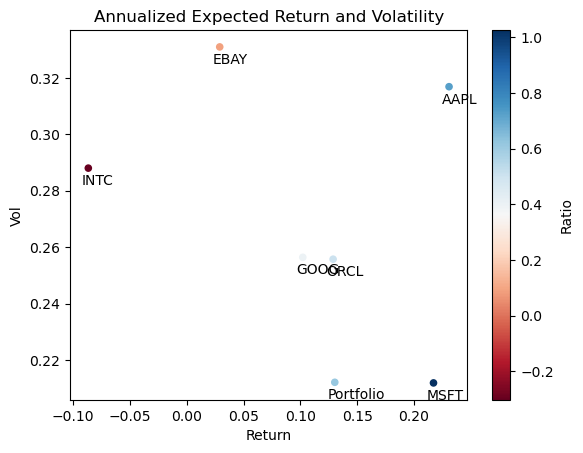

In [15]:
plt = exp_values.plot(kind='scatter', x='Return', y='Vol', c='Ratio', colormap='RdBu', title='Annualized Expected Return and Volatility')
offset = 0.006
for row in exp_values[['Return', 'Vol']].itertuples():
    plt.text(row.Return-offset, row.Vol-offset, row.Index)

<Axes: title={'center': 'Cumulative Log Returns'}, xlabel='Date'>

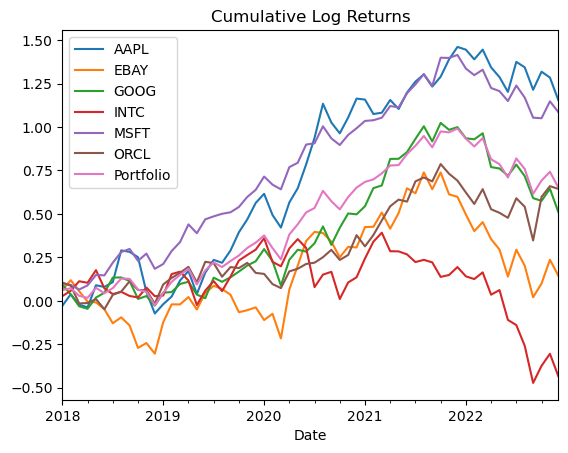

In [16]:
rts_monthly_l.cumsum().plot(kind='line', title='Cumulative Log Returns')

Given the universe of these 6 stocks, Apple and Microsoft were the best ones to own through this time period both on an absolute and risk adjusted return basis. The equally-weighted portfolio underperfoms these two stocks, in large part driven by Intel having a negative return over this time frame and Ebay being close to flat. 

The portfolio started as equally-weighted but, due to appreciation/depreciation of positions, by the end of the time period more than half of the portfolio value was between the MSFT and AAPL positions.

## Question 4

Note: the derivation of variance and kurtosis measures is attached along with answers to questions 1 and 2.

In [17]:
# get beginning of month mask from the daily price data
bmonth_mask = adj_close.index.month[1:] !=  adj_close.index.month[:-1]
bmonth_mask = np.insert(bmonth_mask, 0, True)
# filter out beginning of month prices
bmonth_prices = adj_close.loc[bmonth_mask, 'MSFT']
# calculate arithmetic returns
rts_msft = calc_returns(bmonth_prices, return_type='arithmetic')

In [18]:
moments_msft = calc_central_moments(rts_msft)
moments_msft

,MSFT
mean,0.021734
variance,0.004278
skewness,-0.161917
kurtosis,2.14154


In [19]:
from sympy import symbols, nonlinsolve, Symbol

In [37]:
v = moments_msft.loc['variance', 'MSFT']
k = moments_msft.loc['kurtosis', 'MSFT']
p = 0.999

In [38]:
s1 = Symbol('s1', real=True)
s2 = Symbol('s2', real=True)

In [39]:
eq1 = p*(s1**2) + (1-p)*(s2**2) - v
eq2 = (3*p*((s1**4)) + 3*(1-p)*((s2**4)))/((p*(s1) + (1-p)*(s2))**2) - k
system =  [eq1, eq2]

In [40]:
eq1

0.999*s1**2 + 0.001*s2**2 - 0.00427755902299322

In [41]:
eq2

-2.14153970703453 + 1.00200300400501*(2.997*s1**4 + 0.003*s2**4)/(s1 + 0.001001001001001*s2)**2

In [42]:
soln = nonlinsolve(system, [s1, s2])

In [43]:
soln

{(-0.0536850286412135, 1.18252222181457), (-0.0532057853200835, -1.20396606557569), (0.0532057853200835, 1.20396606557569), (0.0536850286412135, -1.18252222181457), (-0.0800696806875238 - 0.000292898291831989*I, 0.0160631363822111 - 1.45854582011454*I), (-0.0800696806875238 + 0.000292898291831989*I, 0.0160631363822111 + 1.45854582011454*I), (0.0800696806875238 - 0.000292898291831989*I, -0.0160631363822111 - 1.45854582011454*I), (0.0800696806875238 + 0.000292898291831989*I, -0.0160631363822111 + 1.45854582011454*I)}

The above is clearly giving wrong solutions with complex numbers. I am not sure what I am doing wrong and I ran out of time. If the results were correct I would be able to plot them.
- I can iterate values of p from 0.8 to 0.999 at intervals of say 0.01 or 0.001
- if at each inverval there's more than one solution I would choose the one where s2 > s1 and where both values are position

My intuition for results is as follows:

- s1 (std during robust regime) is lower than std of MSFT and s2 (std during destressed regime) is higher
- as p approaches 1 s1 will converge to standard deviation of MSFT
- as p approaches 1 s2 increases (the less frequently the more volatile environment happens, the more extreme the events have to be to increase the volatility of the stock)